# **Mathematics for new Technologies in Finance project**

### Author: Pablo Cuesta Sierra

### Date: 26 April 2025.

Here are the instructions or project description provided by the course organizers:

> The project should contain:
>
> (1) a scenario generator, which generates training and testing scenarios. You should compare three models, namely Black-Scholes, CEV and Heston models. The scenarios should be generated by an Euler method.
>
> (2) specification of a utility function (logarithmic, power or exponential). Select only one of them.
>
> (3) specification of two artificial trading agents. Both should trade at the same, finitely many times. The former should make use of a Markovian strategy, dependent on time, current wealth, and current stock price. The latter should use a path-dependent strategy, taking into account the whole price and the wealth path until that time.
>
> (4) Train the two agents with a loss function defined by (estimated) negative expected utility. Use the same loss function for both the agents.
>
> (5) Discuss and illustrate the results.


## 1. Scenario generation
_You should compare three models, namely Black-Scholes, CEV and Heston models. The scenarios should be generated by an Euler method._

In [1]:
import sys  # only to print python version
import numpy as np
import torch
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import (
    Concatenate, Lambda,
)
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

print(f"{tf.__version__=}")
print(f"{sys.version=}")


tf.__version__='2.18.0'
sys.version='3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]'


#### **Scenario Generator abstract class**

We first create an abstract class `ScenarioGenerator`, which impliments a general Euler-Maruyama simulation. Subclasses of this abstract class will only have to implement the drift and diffusion functions, as well as another function that generates the price process, which will be elementary thanks to the Euler-Maruyama implementation.

`ScenarioGenerator` solves an SDE of the form
$$
dX_t = \operatorname{drift}(t, X_t)dt + \operatorname{diffusion}(t, X_t)dW_t,
$$
$$
X_0 = x \in \mathbb R^d,
$$

where
* $X$ is $\mathbb R^d$-valued,
* $\operatorname{drift}(t, X_t)$ is $\mathbb R^d$-valued,
* $\operatorname{diffusion}(t, X_t)$ is $\mathbb R^{d\times b}$-valued,
* $W$ is $\mathbb R^b$-Brownian Motion.


In [2]:
#@title `ScenarioGenerator` class
class ScenarioGenerator(ABC):
    r"""
    Abstract base class for financial scenario generators using Euler-Maruyama
    discretization.
    This class solves the SDE of the form:
    dX_t = drift(t, X_t) * dt + diffusion(t, X_t) @ dW_t
    where (for each path t \mapsto X_t(omega)):
        - X_t is of dimension (path_dim,),
        - drift(t, X_t) is of dimension (path_dim,),
        - diffusion(t, X_t) is of dimension (path_dim, bm_dim),
        - dW_t is of dimension (bm_dim,)
            (where bm_dim is the number of INDEPENDENT Brownian motions).
    """
    def __init__(
        self,
        maturity=1.0,
        time_steps=252,
        initial_value=0,
    ):
        """
        Initialize scenario generator
        Parameters:
        -----------
        maturity : float
            Time horizon in years
        time_steps : int
            Number of time steps
        seed : int
            Random seed for reproducibility
        """
        self.maturity = maturity
        self.time_steps = time_steps
        self.dt = maturity / time_steps
        self.initial_value = initial_value

    def set_seed(self, seed):
        """Set seeds for reproducibility"""
        np.random.seed(seed)
        torch.manual_seed(seed)
        tf.random.set_seed(seed)

    @abstractmethod
    def drift(self, t, x):
        """
        Calculate the drift coefficient at time t and state x
        Parameters:
        -----------
        t : float
            Current time
        x : numpy array
            Current state. Shape: (n_paths, path_dim)
        Returns:
        --------
        drift : numpy array
            Drift coefficient. Shape: (n_paths, path_dim)
        """
        pass

    @abstractmethod
    def diffusion(self, t, x):
        """
        Calculate the diffusion coefficient at time t and state x
        Parameters:
        -----------
        t : float
            Current time
        x : numpy array
            Current state. Shape: (n_paths, path_dim)
        Returns:
        --------
        diffusion : numpy array
            Diffusion coefficient. Output shape should be
            (n_paths, path_dim, bm_dim)
        """
        pass

    def euler_maruyama(self, x0, n_paths, seed=0):
        """
        Simulate paths using Euler-Maruyama discretization
        Parameters:
        -----------
        x0 : float or numpy array
            Initial state
        n_paths : int
            Number of paths to simulate
        Returns:
        --------
        paths : numpy array
            Simulated paths. Shape (time_steps + 1, n_paths, path_dim)
        """
        self.set_seed(seed)
        path_dim = x0.shape[1]
        sample_diffusion = self.diffusion(0, x0)
        sample_drift = self.drift(0, x0)
        assert sample_diffusion.shape[1] == path_dim, (
            f"Diffusion shape mismatch: "
            f"{sample_diffusion.shape[1]=} != {path_dim=}"
        )
        assert sample_drift.shape[1] == path_dim, (
            f"Drift shape mismatch: "
            f"{sample_drift.shape[1]=} != {path_dim=}"
        )
        bm_dim = sample_diffusion.shape[1]
        paths = np.zeros((self.time_steps + 1, n_paths, path_dim))
        paths[0, :] = x0
        dW_t = np.random.normal(
            0, np.sqrt(self.dt),
            (self.time_steps, n_paths, bm_dim),
        )
        for t in range(self.time_steps):
            diffusion_term = np.einsum(
                "npb, nb -> np",
                self.diffusion(t, paths[t]),  # (n_paths, path_dim, bm_dim)
                dW_t[t],                      # (n_paths, bm_dim)
            )
            # paths[t + 1].shape == (n_paths, path_dim)
            paths[t + 1] = (
                paths[t] +
                self.drift(t, paths[t]) * self.dt +  # (n_paths,)
                diffusion_term
            )
        return paths

    def generate(self, n_paths, seed=0):
        """
        Generate scenarios
        Parameters:
        -----------
        n_paths : int
            Number of paths to simulate
        seed : int
            Random seed for reproducibility
        Returns:
        --------
        paths : numpy array
            Simulated paths. Shape: (time_steps + 1, n_paths, path_dim)
        """
        x0 = np.repeat(self.initial_value, n_paths).reshape(-1, 1)
        return self.euler_maruyama(x0, n_paths, seed)

# Helper function for plotting:
def plot_price_paths(prices, title, maturity):
    """Plots the price paths (shape (time_steps+1, n_paths, path_dim))."""
    assert prices.shape[2] == 1, "Higher dimensions not implemented"
    plt.figure(figsize=(5, 3))
    plt.plot(np.arange(prices.shape[0]) * maturity / (prices.shape[0] - 1), prices[:, :, 0])
    plt.title(title)
    plt.xlabel("Time t")
    plt.ylabel("Price $S_t$")
    plt.grid(True)
    plt.show()

#### Black-Scholes generator
The Black-Scholes model models prices according to
$$
    dS_t = S_t ( \mu dt + \sigma dW_t)
$$

In [3]:
#@title `BlackScholesGenerator` class
class BlackScholesGenerator(ScenarioGenerator):
    """
    Black-Scholes model scenario generator
    dS_t = mu*S_t*dt + sigma*S_t*dW_t
    where:
    - S_t is the stock price at time t
    - mu is the drift (expected return)
    - sigma is the volatility
    """
    def __init__(
        self,
        mu=0.05,
        sigma=0.2,
        initial_value=1.0,
        maturity=1.0,
        time_steps=252,
    ):
        super().__init__(maturity, time_steps, initial_value)
        self.mu = mu
        self.sigma = sigma
        self.path_dim = 1
        self.bm_dim = 1

    def drift(self, t, x):
        return self.mu * x

    def diffusion(self, t, x):
        diffusion_term = self.sigma * x
        # Reshape to (n_paths, path_dim, bm_dim) = (n_paths, 1, 1)
        return diffusion_term.reshape(x.shape[0], self.path_dim, self.bm_dim)

Here we have some samples generated by the Black Scholes Generator. We are going to use the same parameters throughout the whole notebook, to avoid confusion:

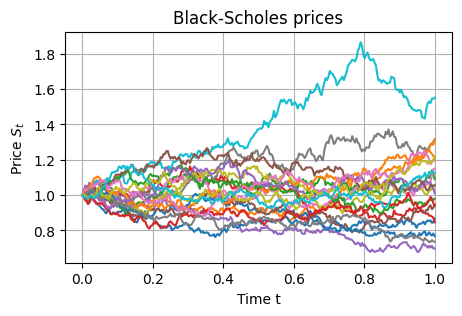

In [4]:
maturity = 1.0  # (in years, but it is not really important)
mu = 0.1
sigma = 0.2
S0 = 1.0  # initial price of the risky asset
black_scholes_prices = BlackScholesGenerator(
    mu=mu,
    sigma=sigma,
    initial_value=S0,
    maturity=maturity,
    time_steps=252,
).generate(n_paths=20, seed=0)
plot_price_paths(
    black_scholes_prices, "Black-Scholes prices", maturity=maturity,
)

#### CEV generator
The [CEV or constant elasticity of variance model](https://en.wikipedia.org/wiki/Constant_elasticity_of_variance_model#Dynamic) is a special case of a local volatility model.
[Local volatility models](https://en.wikipedia.org/wiki/Local_volatility#Formulation) are of the form
$$
    dS_t = S_t ( \mu dt + v(t, S_t) dW_t).
$$
The CEV model has $v(t, S_t) = \sigma S_t^{\gamma - 1}$, for $\sigma,\gamma \geq 0.$

Therefore, the CEV generator will generate sample paths of the SDE

$$
    dS_t = S_t \mu dt + \sigma S_t^\gamma dW_t.
$$


In [5]:
#@title `CEVGenerator` class
class CEVGenerator(ScenarioGenerator):
    """
    Constant Elasticity of Variance (CEV) model scenario generator
    dS_t = mu*S_t*dt + sigma*S_t^gamma*dW_t
    where:
    - S_t is the stock price at time t
    - mu is the drift (expected return)
    - sigma is the volatility scale
    - gamma is the elasticity parameter
    """
    def __init__(
        self,
        mu=0.05,
        sigma=0.2,
        gamma=0.75,
        initial_value=100.0,
        maturity=1.0,
        time_steps=252,
    ):
        super().__init__(maturity, time_steps, initial_value)
        self.mu = mu
        self.sigma = sigma
        self.gamma = gamma
        self.path_dim = 1
        self.bm_dim = 1

    def drift(self, t, x):
        return self.mu * x

    def diffusion(self, t, x):
        diffusion_term = self.sigma * np.power(x, self.gamma)
        # Reshape to (n_paths, path_dim, bm_dim) = (n_paths, 1, 1)
        return diffusion_term.reshape(x.shape[0], self.path_dim, self.bm_dim)

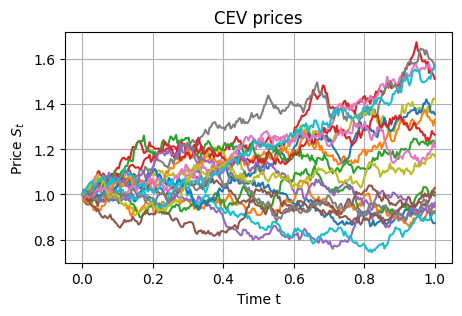

In [6]:
# (we use the same sigma and mu as for the Black Scholes example)
gamma = 0.7
cev_prices = CEVGenerator(
    mu=mu,
    sigma=sigma,
    gamma=gamma,
    initial_value=S0,
    maturity=maturity,
    time_steps=252,
).generate(n_paths=20, seed=1)
plot_price_paths(cev_prices, "CEV prices", maturity=maturity)

#### Heston generator
The prices in the [Heston model](https://en.wikipedia.org/wiki/Heston_model#Mathematical_formulation) are of the form

$$
    dS_t = S_t \mu dt + S_t \sqrt{v_t} dW_t^S,
$$
$$
    dv_t = \kappa (\theta - v_t) dt + \xi \sqrt{v_t} dW_t^v,
$$
where the Brownian Motions $W^S$ and $W^v$ have correlation $\rho.$

If the parameters obey the following condition (known as the Feller condition) then the volatility process $v_t$ is strictly positive:
$$2 \kappa \theta > \xi^2. $$


In [7]:
#@title `HestonGenerator` class
class HestonGenerator(ScenarioGenerator):
    """
    Heston stochastic volatility model scenario generator
    dS_t = mu*S_t*dt + sqrt(v_t)*S_t*dW_t^S
    dv_t = kappa*(theta-v_t)*dt + xi*sqrt(v_t)*dW_t^v
    where:
    - S_t is the stock price at time t
    - v_t is the variance at time t
    - mu is the drift (expected return)
    - kappa is the mean reversion speed of variance
    - theta is the long-term mean variance
    - xi is the volatility of volatility
    - rho is the correlation between the two Brownian Motions
    """
    def __init__(
        self,
        mu=0.05,
        kappa=2.0,
        theta=0.04,
        xi=0.3,
        rho=0.7,
        S0=100.0,
        v0=0.04,
        maturity=1.0,
        time_steps=252,
    ):
        super().__init__(maturity, time_steps)
        self.mu = mu
        self.kappa = kappa
        self.theta = theta
        self.xi = xi
        self.rho = rho
        self.S0 = S0
        self.v0 = v0
        self.path_dim = 2  # Stock price and variance
        self.bm_dim = 2    # Two (independent) Brownian motions

    def drift(self, t, x):
        S = x[:, 0:1]  # Stock price
        v = x[:, 1:2]  # Variance

        # Ensure positive variance (numerical stability)
        v = np.maximum(v, 1e-10)

        # Drift for S_t: mu*S_t
        drift_S = self.mu * S

        # Drift for v_t: kappa*(theta-v_t)
        drift_v = self.kappa * (self.theta - v)

        # Combine drifts
        return np.hstack([drift_S, drift_v])

    def diffusion(self, t, x):
        n_paths = x.shape[0]
        S = x[:, 0:1]  # Stock price
        v = x[:, 1:2]  # Variance

        # Ensure positive variance (numerical stability)
        v = np.maximum(v, 1e-10)

        # Calculate square root of variance
        sqrt_v = np.sqrt(v)

        # Initialize diffusion matrix for each path
        # Shape: (n_paths, 2, 2)
        diffusion = np.zeros((n_paths, self.path_dim, self.bm_dim))

        # Set diffusion terms
        # S_t diffusion w.r.t. W^1: sqrt(v_t)*S_t
        diffusion[:, 0, 0] = sqrt_v.flatten() * S.flatten()

        # S_t diffusion w.r.t. W^2: 0
        diffusion[:, 0, 1] = 0

        # v_t diffusion w.r.t. W^1: rho*xi*sqrt(v_t) (correlated part)
        diffusion[:, 1, 0] = self.rho * self.xi * sqrt_v.flatten()

        # Variance diffusion w.r.t. W^2: xi*sqrt(v_t)*sqrt(1-rho^2)
        # (orthogonal part)
        diffusion[:, 1, 1] = (
            self.xi * sqrt_v.flatten() * np.sqrt(1 - self.rho**2)
        )

        return diffusion

    def generate(self, n_paths, seed=0):
        """
        Generate Heston scenarios and return the Stock prices only (no variance)

        Parameters:
        -----------
        n_paths : int
            Number of paths to simulate
        seed : int
            Random seed for reproducibility

        Returns:
        --------
        paths : numpy array
            Simulated paths. Shape: (time_steps+1, n_paths, 1)
            paths[:,:,0] contains stock prices
            paths[:,:,1] contains variances (not returned)
        """
        # Initialize state with S0 and v0
        # Shape: (n_paths, 2)
        x0 = np.zeros((n_paths, self.path_dim))
        x0[:, 0] = self.S0
        x0[:, 1] = self.v0

        # only return prices
        return self.euler_maruyama(x0, n_paths, seed)[:, :, 0:1]

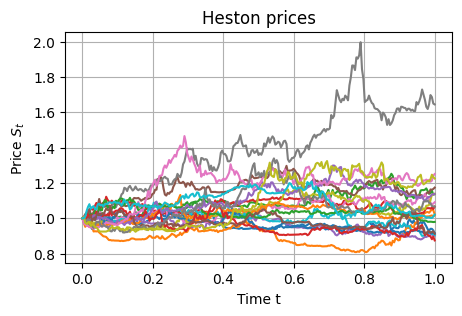

In [8]:
kappa = 5.0
theta = 0.04
v0 = 0.04
xi = 0.62
rho = 0.7
assert 2 * kappa * theta > xi ** 2, f"{2 * kappa * theta=} <= {xi ** 2=}"
heston_prices = HestonGenerator(
    mu=mu,
    kappa=kappa,
    theta=theta,
    xi=xi,
    rho=rho,
    S0=S0,
    v0=v0,
    maturity=maturity,
    time_steps=252,
).generate(n_paths=20, seed=2)
plot_price_paths(heston_prices, "Heston prices", maturity=maturity)

## 2. Specification of a utility function
_(Logarithmic, power or exponential). Select only one of them._

* The [exponential utility function](https://en.wikipedia.org/wiki/Exponential_utility) has the form $$u_{\operatorname{exp}}^a(x) = \frac {1-e^{-ax}}{a},$$
for the parameter $a > 0,$ and
$$u_{\operatorname{exp}}^0(x) = x = \lim_{a\to 0}e_{\operatorname{exp}}^a(x), \quad \forall x\geq 0.$$
for $a = 0$.
(If $a<0$, then $u_{\operatorname{exp}}^a$ is convex).

In [9]:
def exponential_utility_function(a):
    if a < 0:
        raise ValueError("Utility function should be concave")
    if a == 0:
        return lambda x: x
    else:  # a != 0
        return lambda x: (1.0 - tf.math.exp(-a * x)) / a

* The [CRRA (Constant Relative Risk Aversion)](https://en.wikipedia.org/wiki/Isoelastic_utility) utility function has the form
$$
u_{\operatorname{crra}}^\gamma(x) = \frac{x^\gamma - 1} \gamma
$$
for the parameter $0 < \gamma < 1,$ and
$$u_{\operatorname{crra}}^0(x) = \log x = \lim_{a\to 0}e_{\operatorname{crra}}^\gamma(x), \quad \forall x\geq 0.$$
for $\gamma = 0$.
* We call $u_{\operatorname{crra}}^0 = \log $ the Logarithmic utility function.

Note that $u_{\operatorname{crra}}^1$ and $u_{\operatorname{exp}}^0$ are equivalent (up to translation).

In [10]:
def crra_utility_function(gamma):
    if gamma < 0 or gamma > 1:
        raise ValueError(f"{gamma=} invalid for the CRRA utility function")
    if gamma == 0:
        return lambda x: tf.math.log(x)
    else:  # 0 < gamma < 1
        return lambda x: (tf.math.pow(x, gamma) - 1.0) / gamma

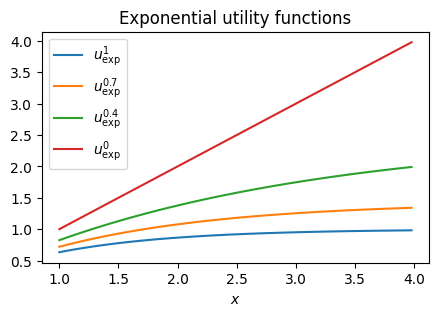

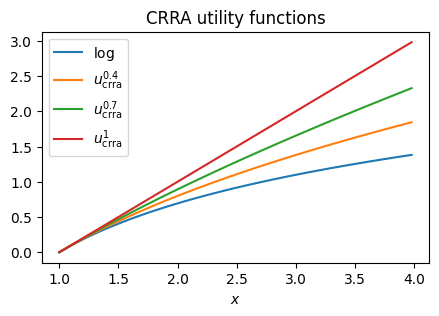

In [11]:
#@title Utility functions examples
def plot_functions(
    functions: dict,
    title: str,
):
    x = np.logspace(0, 0.6, 100)
    plt.figure(figsize=(5,3))
    for name, f in functions.items():
        plt.plot(x, f(x), label=name)
    plt.xlabel("$x$")
    plt.legend()
    plt.title(title)
    plt.show()

plot_functions({
    "$u_{\operatorname{exp}}^1$": exponential_utility_function(a=1),
    "$u_{\operatorname{exp}}^{0.7}$": exponential_utility_function(a=0.7),
    "$u_{\operatorname{exp}}^{0.4}$": exponential_utility_function(a=0.4),
    "$u_{\operatorname{exp}}^0$": exponential_utility_function(a=0),
}, "Exponential utility functions")
plot_functions({
    "$\log$": crra_utility_function(gamma=0),
    "$u_{\operatorname{crra}}^{0.4}$": crra_utility_function(gamma=0.4),
    "$u_{\operatorname{crra}}^{0.7}$": crra_utility_function(gamma=0.7),
    "$u_{\operatorname{crra}}^1$": crra_utility_function(gamma=1),
}, "CRRA utility functions")

We are going to use the logarithmic utility function:

In [12]:
utility_function = crra_utility_function(gamma=0)

## 3. Specification of two artificial trading agents.
_Both should trade at the same, finitely many times. The former should make use of a Markovian strategy, dependent on time, current wealth, and current stock price. The latter should use a path-dependent strategy, taking into account the whole price and the wealth path until that time._

### 3.1. Markovian agent
We first show the Markovian agent, implemented in the class `MarkovianAgent`. It consists of a single feed-forward Neural Network $f_\theta(t, X_t, S_t)$ that takes time ($t$), current wealth ($X_t$) and current risky asset price ($S_t$), and outputs the proportion $\alpha_t$ that is invested at time $t$ in the stock. Thus, given the stock price process $S$, the wealth process $X$ follows the dynamics:
$$\alpha_t = f_\theta(t, X_t, S_t),$$
$$dX_t = \alpha_tX_t\frac{dS_t}{S_t} + (1-\alpha_t)X_t r dt,\qquad \text{(Wealth SDE)}$$
where $r$ is a constant denoting the constant interest rate of the deterministic (non-risky) asset $dB_t = rB_t dt.$ Without loss of generality, we will set by default $X_0 = 1.$

Note that $\alpha_t$ is a measurable function of $X_t$ and $S_t$, so the process $\alpha$ is adapted to the filtration $(\mathcal F_t)_{t\geq 0}$ generated by $S$ (and $X$).

Our model takes as input a sample price path $(S_{t}(\omega))_{t\in D}$ evaluated at discrete, equispaced time-points $D = \{t_i := \frac{iT}{N}: 0\leq i\leq N\}$, where $T$ is the total time of the investment horizon and $N+1$ the amount of time-steps in the discretization.

The model outputs a tuple $(\hat X_T(\omega), (\alpha_t)_{t\in D\setminus \{T\}})$, where $\hat X$ is the estimated wealth via Euler-Maruyama discretization of (Wealth SDE), and $\alpha_t := f_\theta(t, \hat X_t, S_t)$ for each $t$. Note that we are not "looking into the future", as the strategy $\alpha_t$ at time $t$ is $\mathcal F_t$-measurable, so the simple integrand
$$
\alpha_t = \sum_{i=0}^{N-1}f_\theta(t_i, \hat X_{t_i}, S_{t_i})\ \chi_{(t_i, t_i+1]}(t)
$$
induced by the Euler-Maruyama discretization of (Wealth SDE) is indeed left-continuous and adapted, thus predictable with respect to $(\mathcal F_t)_{t\in[0, T]}$.

We want to compute the optimal parameter $\theta$ such that $E[u(\hat X_T)]$ computed this way is maximized, $u$ being the utility function. Therefore, our training process consists on passing many sample paths $(S_{t}(\omega_j))_{t\in D,\ 1 \leq j \leq \text{#samples}}$ repeated times through the described architecture (Euler-Maruyama scheme + computing coefficients $\alpha_t$ via $f_\theta$) in order to learn the parameter $\theta$ that minimizes the negative mean (i.e. estimated expected value) utility:
$$\text{minimize:}\qquad \frac{1}{\text{#samples}} \sum_j u(\hat X_T(\omega_j)).$$

(This explantion is a bit oversimplified: the training will be done in batches, as is usual; but this is a good way to think about it).

We could also modify this agent so that our neural network takes perhaps less parameters: e.g. no time-dependence $f_\theta(X_t, S_t)$, or just $f_\theta(S_t)$, or we could even take the neural network to be constant $f_\theta = \theta\in\mathbb R.$



In [13]:
class MarkovianAgent:
    """
    A trading agent using a Markovian strategy that depends on time, current
    wealth, and current stock price (these dependencies can be dropped when
    initializing the agent). This agent uses a neural network to
    determine the proportion of wealth to invest in the risky asset at each
    time step.

    Parameters:
    -----------
    maturity : float
        Total time of the investment horizon
    time_steps : int
        Total number of trading times
    hidden_units : list
        List of hidden layer units
    learning_rate : float
        Learning rate for the optimizer
    risk_free_interest_rate : float
        Risk-free interest rate r
    utility_function: callable
        The utility function that the trading agent has to maximize
    time_dependent: bool
        Whether the neural network depends on the current time
    wealth_dependent: bool
        Whether the neural network depends on the current wealth value
    price_dependent: bool
        Whether the neural network depends on the current stock price
    """

    def __init__(
        self,
        maturity=1.0,
        time_steps=252,
        hidden_units=[64, 32],
        learning_rate=0.001,
        risk_free_interest_rate=0.05,
        utility_function=utility_function,
        time_dependent=True,
        wealth_dependent=True,
        price_dependent=True,
    ):
        self.maturity = maturity
        self.r = risk_free_interest_rate
        self.dt = maturity / time_steps
        self.time_steps = time_steps
        self.time_dependent = time_dependent
        self.wealth_dependent = wealth_dependent
        self.price_dependent = price_dependent
        self.input_dim = (
            time_dependent + wealth_dependent + price_dependent
        )
        self.hidden_units = hidden_units
        self.learning_rate = learning_rate
        self.utility_function = utility_function
        self.model = self.compile_model()

    def compile_model(self):
        """
        Build a neural network model for the Markovian agent and return the
        compiled model.

        Returns:
        --------
        model : keras.Model
            Compiled Keras model

        The model has the following architecture:
            We have a single neural network with hidden layers.
            - Input layer with 3 features (time, wealth, price)
            - hidden layers with Tanh activation and number of neurons
                as specified in self.hidden_units.
            - Output layer to predict the proportion
                of wealth to invest in the risky asset: alpha_t
            The input to the model is [S_input], where S_input is a sequence of
                prices S of shape (batch, time_steps + 1), where S[:, 0] is the
                initial price.
            The output of the model is [wealth, strategy], where wealth is
                the wealth at time T and strategy is the sequence of
                proportions of wealth invested in the risky asset at each
                time step.
                wealth is of shape (batch, 1) and
                strategy is of shape (batch, time_steps, 1).

        The output of the NN alpha_t is the
        proportion of the wealth that is invested in the risky asset at each
        time step.
        The wealth process X is given by the following equation:

        dX_t = alpha_t*X_t*dS_t/S_t + (1 - alpha_t)*X_t*r*dt,

        where dS_t/S_t is the return of the risky asset and r*dt is the
        return of the risk-free asset.

        We are maximizing the expected utility of the wealth process X at
        time T.
        """
        # Input sequence: price process S of shape (batch, time_steps + 1, 1)
        price_input = keras.Input(shape=(self.time_steps + 1, 1), name="price")

        # Initial wealth: shape (batch, 1)
        initial_wealth = Lambda(lambda s: tf.ones_like(s[:, 0]))(price_input)
        wealth = initial_wealth

        def build_alpha_network():
            inputs = keras.Input(shape=(self.input_dim or 1,))
            x = inputs
            for i, units in enumerate(self.hidden_units):
                x = keras.layers.Dense(
                    units,
                    trainable=True,
                    kernel_initializer="random_normal",
                    bias_initializer="random_normal",
                    activation="tanh",
                    name=f"hidden_{i}",
                )(x)
            output = keras.layers.Dense(
                1,
                trainable=True,
                kernel_initializer="random_normal",
                bias_initializer="random_normal",
                activation="linear",
                name="hidden_last",
            )(x)
            return keras.Model(
                inputs=inputs, outputs=output, name="alpha_theta",
            )

        alpha_net = build_alpha_network()
        strategy_list = []  # collect alpha_t at each time step
        ones = Lambda(lambda s: tf.ones_like(s))(price_input[:, 0])  # (batch, 1)

        for t in range(self.time_steps):
            S_t = price_input[:, t]       # S[t]  : (batch, 1)
            S_tp1 = price_input[:, t+1]   # S[t+1]: (batch, 1)

            # Create time tensor (batch, 1) (we normalize it to [0, 1])
            t_tensor = ones * (t / self.time_steps)

            inputs = [
                *([t_tensor] if self.time_dependent else []),
                *([wealth] if self.wealth_dependent else []),
                *([S_t] if self.price_dependent else []),
            ] or [ones]  # constant input if empty === constant neural network
            net_input = Concatenate(axis=-1)(inputs)

            # Compute alpha_t (note that S[t+1] is not used at all for this)
            alpha_t = alpha_net(net_input)  # (batch, 1)
            strategy_list.append(alpha_t)

            # Compute wealth at time t+1
            wealth = wealth * (
                1
                + alpha_t * (S_tp1 - S_t) / S_t
                + (1 - alpha_t) * self.r * self.dt
            )

        # strategy: (batch, time_steps, 1)
        strategy = Lambda(
            lambda x: tf.stack(x, axis=1), name="strategy"
        )(strategy_list)
        # wealth: (batch, 1)
        final_wealth = Lambda(lambda x: x, name="final_wealth")(wealth)

        model = keras.Model(
            inputs=price_input,
            outputs={"final_wealth": final_wealth, "strategy": strategy},
            name="MarkovianAgent",
        )

        def negative_utility_loss(y_true, y_pred):
            return -K.mean(self.utility_function(y_pred))

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate),
            loss={"final_wealth": negative_utility_loss},
            metrics={"final_wealth": [
                lambda y_true, y_pred: -K.mean(self.utility_function(y_pred)),
            ]},
        )

        return model



### 3.2. Non-Markovian agent

The non-markovian agent that will follow the same exact architecture. The modification that we are going to give it so it becomes non-markovian is that the neural network is going to take more *past* path information than just the *current* price and wealth. Some options are:
* $f_\theta(t, (X_s, S_s)_{D\ni s\leq t})$, but this means that for each $t$ the inputs are different, so to implement this we may have to put $|D|$ neural networks $f_{\theta_t}^t$ with different input sizes so that
$$\alpha_{t_i} = f_{\theta_{t_i}}^{t_i}((X_{t_j}, S_{t_j})_{j\leq i}).$$
I want to avoid having an increasing number of neural networks if we increase the number of time-steps. Moreover, I believe that it will not be necessary to increase the number of trainable parameters if the number of time-steps increases, so we can use the second option:
* $f_\theta(t, h[(X_{t_j}, S_{t_j})_{j\leq i}])$, where $h$ should be a summary of the information of the paths, maybe even of (recurrent?) neural-network form. Some examples are:
    * Last steps information:
\begin{equation}
h[(X_{t_j}, S_{t_j})_{j\leq i}] = (X_{t_{i-k}}, \dots, X_{t_{i}}, S_{t_{i-k}}, \dots, S_{t_{i}})
\end{equation}
    * Truncated signature information:
\begin{equation}
h[(X_{s}, S_{s})_{s\leq t}] = \operatorname{sig}^{\leq n}_{0, t}(X, S)
\end{equation}
    * Let $g_{\tilde\theta}$ be an $\mathbb R^d$-valued neural network taking $\mathbb{R}^{d+2}$-valued inputs so that

$$
h[(X_{t_j}, S_{t_j})_{j\leq i}] = g_{\tilde \theta}(X_{t_i},S_{t_i},h[(X_{t_j}, S_{t_j})_{j\leq i - 1}]).
$$

$$
\text{Another possibility would be:}\quad
h[(X_{t_j}, S_{t_j})_{j\leq i}] = h[(X_{t_j}, S_{t_j})_{j\leq i - 1}] + g_{\tilde \theta}(X_{t_i},S_{t_i}).
$$

For simplicity, the one that I am going to choose is a variation of the third one in the sublist above. Namely, we will use the same architecture as the Markovian agent: use the Euler-Maruyama discretization of (Wealth SDE) and compute at each step
$$\alpha_{t_i} = f_\theta(t_i, X_{t_i}, S_{t_i}, h_{i}),$$
where
$$h_0 = 0, \quad \text{and}\quad h_{i} = g_{\tilde \theta}(X_{t_i}, S_{t_i}, h_{i-1}).$$
Here $\theta$ and $\tilde \theta$ are the trainable parameters of two neural networks $f_\theta$ and $g_{\tilde \theta}.$

$h_i$ can be interpreted as a summary of the information of the paths $(X, S)$ up to time $t_i$.

In [14]:
class NonMarkovianAgent:
    """
    Non-Markovian trading agent with recursive memory:
    h_t = g_theta(X_t, S_t, h_{t-1})
    alpha_t = f_theta(t, h_t)

    Parameters:
    -----------
    maturity : float
        Investment horizon
    time_steps : int
        Number of trading steps
    hidden_units_h : list
        Hidden layer sizes for g_theta (hidden state updater)
    hidden_units_alpha : list
        Hidden layer sizes for f_theta (alpha calculator)
    hidden_dim : int
        Dimension of hidden state h_t
    learning_rate : float
        Learning rate for optimizer
    risk_free_interest_rate : float
        Interest rate of the non-risky asset
    utility_function : callable
        Utility function u(X_T)
    """

    def __init__(
        self,
        maturity=1.0,
        time_steps=252,
        hidden_units_h=[64],
        hidden_units_alpha=[64, 32],
        hidden_dim=16,
        learning_rate=0.001,
        risk_free_interest_rate=0.05,
        utility_function=utility_function,
    ):
        self.maturity = maturity
        self.dt = maturity / time_steps
        self.time_steps = time_steps
        self.r = risk_free_interest_rate
        self.hidden_dim = hidden_dim
        self.hidden_units_h = hidden_units_h
        self.hidden_units_alpha = hidden_units_alpha
        self.learning_rate = learning_rate
        self.utility_function = utility_function
        self.model = self.compile_model()

    def compile_model(self):
        price_input = keras.Input(shape=(self.time_steps + 1, 1), name="price")

        ones = Lambda(lambda s: tf.ones_like(s[:, 0]))(price_input)
        initial_wealth = Lambda(lambda s: tf.ones_like(s[:, 0]))(price_input)
        wealth = initial_wealth

        h = Lambda(
            lambda s: tf.zeros((tf.shape(s)[0], self.hidden_dim))
        )(price_input)

        def build_h_network():
            inputs = keras.Input(shape=(self.hidden_dim + 2,))
            x = inputs
            for units in self.hidden_units_h:
                x = keras.layers.Dense(units, activation='tanh')(x)
            output = keras.layers.Dense(self.hidden_dim, activation='tanh')(x)
            return keras.Model(inputs=inputs, outputs=output, name="g_theta")

        def build_alpha_network():
            inputs = keras.Input(shape=(self.hidden_dim + 3,))
            x = inputs
            for units in self.hidden_units_alpha:
                x = keras.layers.Dense(units, activation='tanh')(x)
            output = keras.layers.Dense(1, activation='linear')(x)
            return keras.Model(
                inputs=inputs, outputs=output, name="alpha_theta",
            )

        h_net = build_h_network()
        alpha_net = build_alpha_network()

        strategy_list = []

        for t in range(self.time_steps):
            S_t = price_input[:, t]
            S_tp1 = price_input[:, t + 1]

            t_tensor = ones * (t / self.time_steps)  # normalized time

            # Update hidden state: h_t = g_theta(X_t, S_t, h_{t-1})
            g_input = Concatenate(axis=-1)([wealth, S_t, h])
            h = h_net(g_input)

            # Compute alpha_t = f_theta(t, X_t, S_t, h_t)
            alpha_input = Concatenate(axis=-1)([t_tensor, wealth, S_t, h])
            alpha_t = alpha_net(alpha_input)
            strategy_list.append(alpha_t)

            # Euler-Maruyama update for wealth
            wealth = wealth * (
                1
                + alpha_t * (S_tp1 - S_t) / S_t
                + (1 - alpha_t) * self.r * self.dt
            )

        strategy = Lambda(
            lambda x: tf.stack(x, axis=1), name="strategy",
        )(strategy_list)
        final_wealth = Lambda(lambda x: x, name="final_wealth")(wealth)

        model = keras.Model(
            inputs=price_input,
            outputs={"final_wealth": final_wealth, "strategy": strategy},
            name="RecurrentAgent",
        )

        def negative_utility_loss(y_true, y_pred):
            return -K.mean(self.utility_function(y_pred))

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate),
            loss={"final_wealth": negative_utility_loss},
            metrics={"final_wealth": [
                lambda y_true, y_pred: -K.mean(self.utility_function(y_pred)),
            ]},
        )

        return model


## 4. Training
_Train the two agents with a loss function defined by (estimated) negative expected utility. Use the same loss function for both the agents._

In [15]:
#@title Some wrapper functions for fitting and predicting
class SelectiveProgbarLogger(tf.keras.callbacks.ProgbarLogger):
    def __init__(self, verbose, epoch_interval, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.default_verbose = verbose
        self.epoch_interval = epoch_interval

    def on_epoch_begin(self, epoch, *args, **kwargs):
        self.verbose = (
            0 if epoch % self.epoch_interval != 0 else self.default_verbose
        )
        super().on_epoch_begin(epoch, *args, **kwargs)


def get_model_inputs(prices):
    """From prices, constructs model inputs for the agents.

    Parameters:
    ----------
    prices : np.ndarray
        The prices of the risky asset over time.
        Shape: (time_steps + 1, batch_size, 1)

    Returns:
    -------
    inputs : list
        List of inputs for the model:
            - prices: (batch_size, time_steps + 1)
    """
    prices = np.transpose(prices, (1, 0, 2))  # (batch_size, time_steps + 1, 1)
    return prices


# Training
def fit(
    agent,
    prices,
    validation_prices=None,
    batch_size=100,
    epochs=100,
    **kwargs,
):
    """Fit the agent's model with given prices.

    Parameters:
    ----------
    agent : MarkovianAgent
        The trading agent to be trained.
    prices : np.ndarray
        The prices of the risky asset over time.
        Shape: (time_steps + 1, batch_size, 1)
    batch_size : int
        The size of the batches for training.
    epochs : int
        The number of epochs for training.
    kwargs: dict
        All other parameters for the fit function of the model.

    Returns:
    -------
    history : keras.callbacks.History
        Training history of the model.
    """
    model_inputs = get_model_inputs(prices)
    dummy_output = {  # Dummy values to satisfy the model
        "final_wealth": np.ones((prices.shape[1], 1), dtype=np.float32),
    }

    if validation_prices is not None:
        dummy_validation_output = {
            "final_wealth": np.ones((validation_prices.shape[1], 1), dtype=np.float32)
        }
        validation_input = get_model_inputs(validation_prices)
        kwargs["validation_data"] = (validation_input, dummy_validation_output)

    history = agent.model.fit(
        x=model_inputs,
        y=dummy_output,  # We don't care about the output
        batch_size=batch_size,
        epochs=epochs,
        **kwargs,
    )

    return history


def predict(agent, prices, verbose=False):
    """Predict the final wealth and strategy of the agent given prices.

    Parameters:
    ----------
    agent : MarkovianAgent
        The trading agent to be trained.
    prices : np.ndarray
        The prices of the risky asset over time.
        Shape: (time_steps + 1, batch_size, 1)

    Returns:
    -------
    wealth : np.ndarray
        The final wealth of the agent that trades according to the predicted
        optimal strategy.
        Shape: (batch_size, 1)
    strategy : np.ndarray
        The predicted (optimal) strategy of the agent.
        Shape: (batch_size, time_steps, 1)
    """
    model_inputs = get_model_inputs(prices)

    # Predict the final wealth and strategy
    predictions = agent.model.predict(
        x=model_inputs,
        batch_size=prices.shape[1],
        verbose=verbose,
    )
    wealth = predictions["final_wealth"]  # (batch_size, 1)
    strategy = predictions["strategy"]  # (batch_size, time_steps, 1)

    return wealth, strategy


Generation of our train and test data (prices).

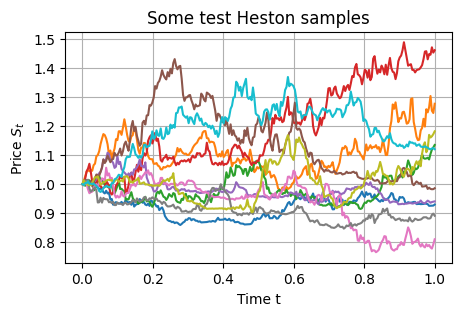

In [16]:
n_paths = {"train" : 10000, "test": 500}
time_steps = 252
generators = {
    "BS": BlackScholesGenerator(
        mu=mu,
        sigma=sigma,
        initial_value=S0,
        maturity=maturity,
        time_steps=time_steps,
    ),
    "CEV": CEVGenerator(
        mu=mu,
        sigma=sigma,
        gamma=gamma,
        initial_value=S0,
        maturity=maturity,
        time_steps=time_steps,
    ),
    "Heston": HestonGenerator(
        mu=mu,
        kappa=kappa,
        theta=theta,
        xi=xi,
        rho=rho,
        S0=S0,
        v0=v0,
        maturity=maturity,
        time_steps=time_steps,
    ),
}
prices = {
    (_type, model_name): generator.generate(
        n_paths=n_paths[_type],
        seed=18753 * i + 35643 * j + 304893,
    )
    for i, (model_name, generator) in enumerate(generators.items())
    for j, _type in enumerate(("train", "test"))
}
model_names = sorted(set(model_name for _type, model_name in prices.keys()))

# For example, here are some samples of the Heston test prices:
plot_price_paths(prices[("test", "Heston")][:, :10], "Some test Heston samples", maturity)

We are going to try out 4 versions of the Markovian trading agent:
* `"twp_markov"`: the neural network depends on current time, wealth and price.
<!-- * `"tp_markov"`: the neural network depends on current time and price. -->
* `"p_markov"`: the neural network depends only on the current price.
* `"const_markov"`: the neural network is constant.

We will also use one of our non-markovian agents: `"nonmarkov"`.

In [17]:
## Trading agents
learning_rate = 1e-3
r = 0.02

agents = {
    "twp_markov": lambda: MarkovianAgent(
        maturity=maturity,
        time_steps=time_steps,
        risk_free_interest_rate=r,
        hidden_units=[10, 10],
        learning_rate=learning_rate,
        time_dependent=True,
        wealth_dependent=True,
        price_dependent=True,
    ),
    # "tp_markov": lambda: MarkovianAgent(
    #     maturity=maturity,
    #     time_steps=time_steps,
    #     risk_free_interest_rate=r,
    #     hidden_units=[8, 8],
    #     learning_rate=learning_rate,
    #     time_dependent=True,
    #     wealth_dependent=False,
    #     price_dependent=True,
    # ),
    "p_markov": lambda: MarkovianAgent(
        maturity=maturity,
        time_steps=time_steps,
        risk_free_interest_rate=r,
        hidden_units=[6, 6],
        learning_rate=learning_rate,
        time_dependent=False,
        wealth_dependent=False,
        price_dependent=True,
    ),
    "const_markov": lambda: MarkovianAgent(
        maturity=maturity,
        time_steps=time_steps,
        risk_free_interest_rate=r,
        hidden_units=[15],  # even if the nn is constant, learning is faster with some neurons (rather than only bias terms)
        learning_rate=learning_rate,
        time_dependent=False,
        wealth_dependent=False,
        price_dependent=False,
    ),
    "nonmarkov": lambda: NonMarkovianAgent(
        maturity=maturity,
        time_steps=time_steps,
        risk_free_interest_rate=r,
        hidden_units_h=[6, 6],
        hidden_units_alpha=[8, 8],
        hidden_dim=6,
        learning_rate=learning_rate,
        utility_function=utility_function,
    ),
}

We now train our different agents with each of the generated samples (BS, CEV, Heston).

The amount of epochs for training is decided dynamically depending on wether the loss decreases between consecutive epochs. See below the variable `callbacks`.

In [18]:
histories = dict()
fitted_agents = dict()

callbacks = [
    keras.callbacks.EarlyStopping(monitor="loss", patience=3),  # stop early if loss does not improve https://keras.io/api/callbacks/early_stopping/
    SelectiveProgbarLogger(verbose=1, epoch_interval=10),
]

for agent_name, agent_creator in agents.items():
    for model_name in model_names:
        agent = agent_creator()
        history = fit(
            agent=agent,
            prices=prices[("train", model_name)],
            validation_prices=prices[("test", model_name)],
            batch_size=500,
            epochs=71,
            callbacks=callbacks,
        )
        fitted_agents[(agent_name, model_name)] = agent
        histories[(agent_name, model_name)] = history

Epoch 1/71
20/20 ━━━━━━━━━━━━━━━━━━━━ 71s 939ms/step - final_wealth_lambda: -0.0215 - loss: -0.0215 - val_final_wealth_lambda: -0.0251 - val_loss: -0.0251
Epoch 11/71
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - final_wealth_lambda: -0.0990 - loss: -0.0990 - val_final_wealth_lambda: -0.0965 - val_loss: -0.0965
Epoch 21/71
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - final_wealth_lambda: -0.0991 - loss: -0.0991 - val_final_wealth_lambda: -0.0964 - val_loss: -0.0964
Epoch 31/71
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - final_wealth_lambda: -0.0991 - loss: -0.0991 - val_final_wealth_lambda: -0.0964 - val_loss: -0.0964
Epoch 41/71
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - final_wealth_lambda: -0.0991 - loss: -0.0991 - val_final_wealth_lambda: -0.0964 - val_loss: -0.0964
Epoch 51/71
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - final_wealth_lambda: -0.0991 - loss: -0.0991 - val_final_wealth_lambda: -0.0964 - val_loss: -0.0964
Epoch 61/71
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - final_wealth_lambda: 

## 5. Discuss and illustrate the results

Next, look at the plots of the loss evolution with respect to the epochs during fit, both for train and test (validation) data, for each of the agents and models.

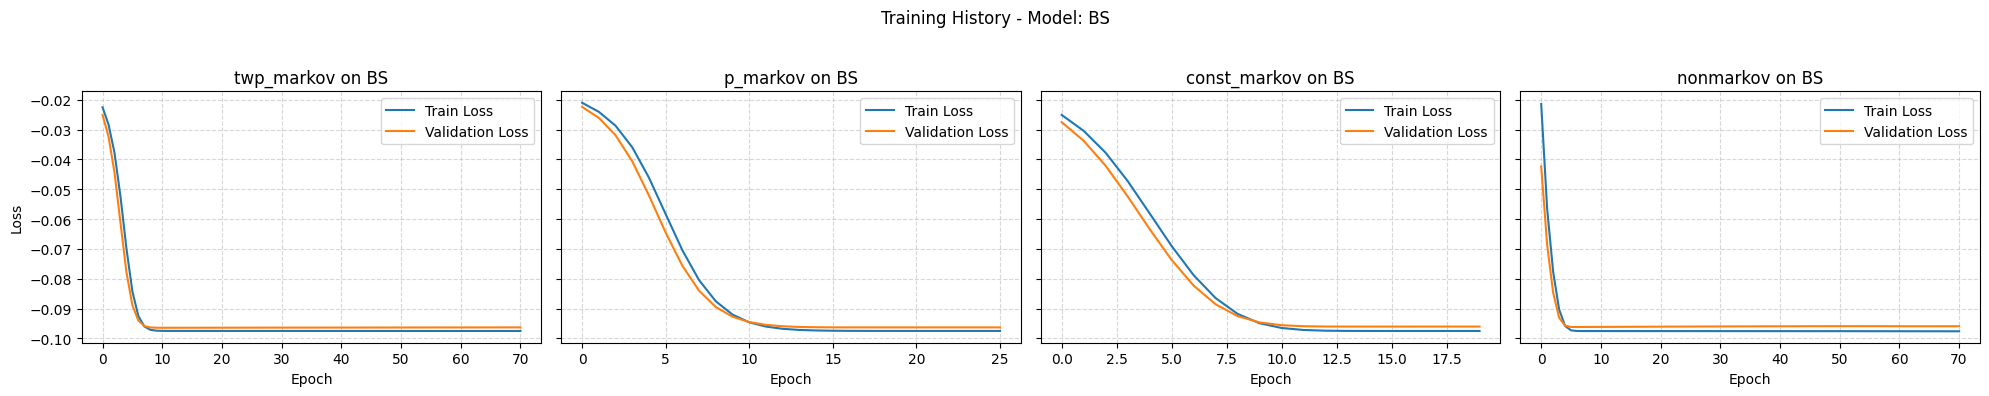

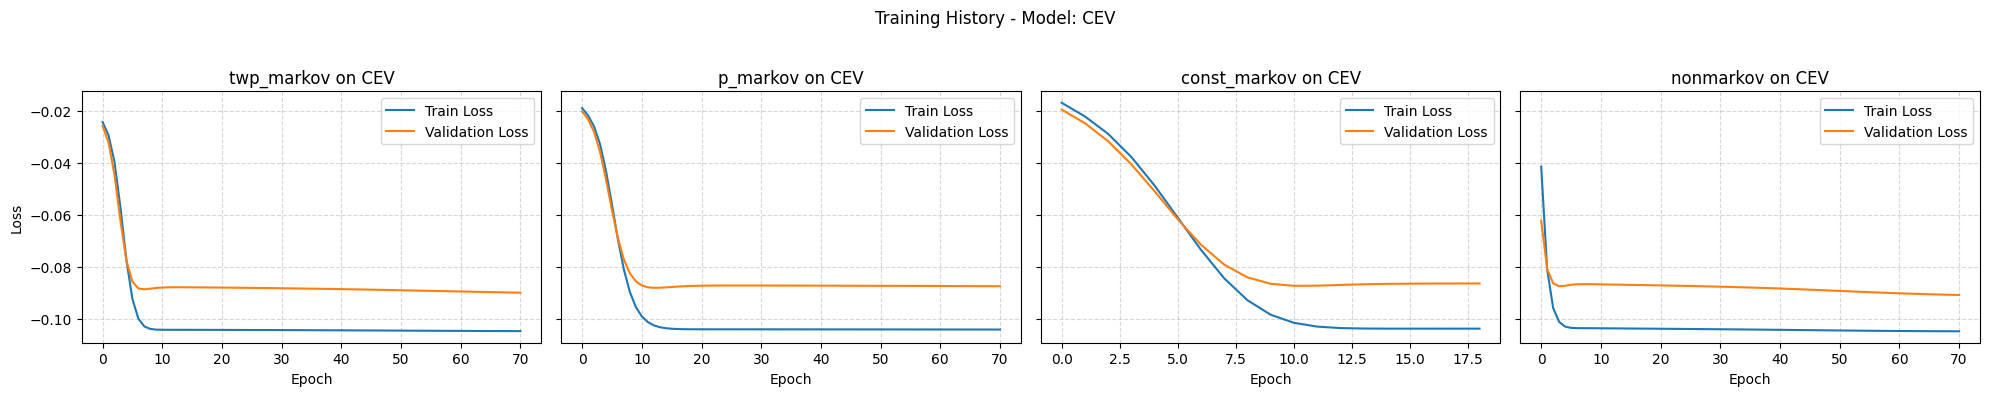

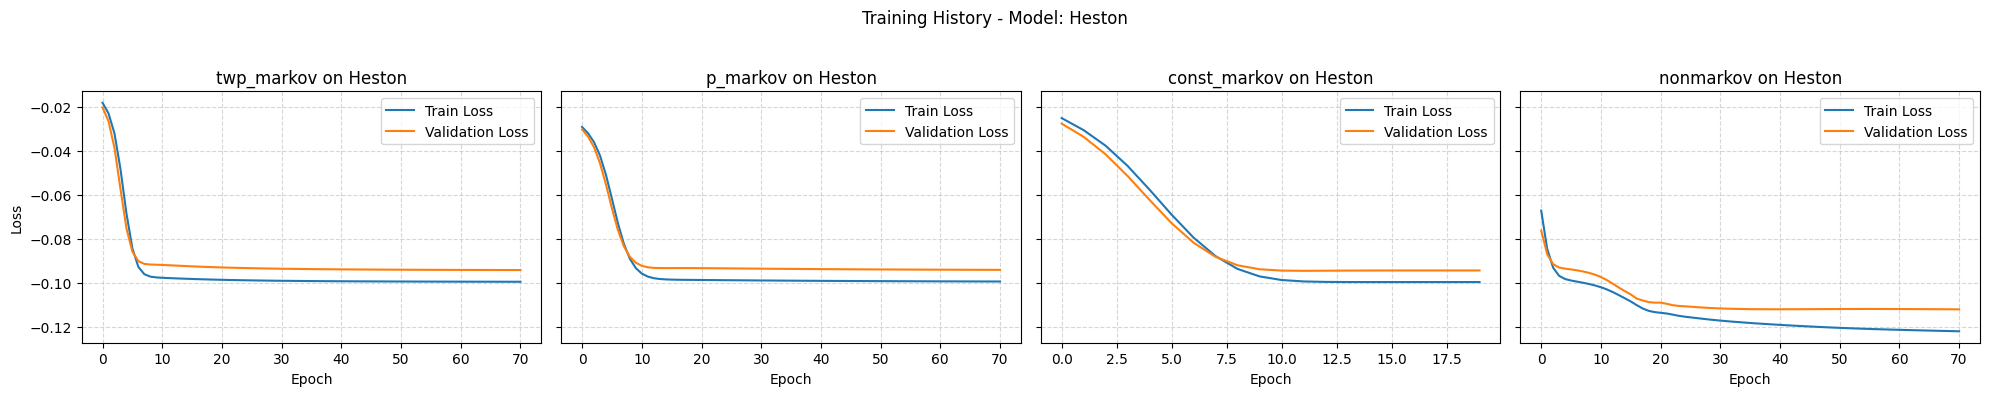

In [19]:
#@title Plot history losses
def plot_history_losses(model_name, histories):
    agent_names = agents.keys()
    fig, axs = plt.subplots(1, len(agent_names), figsize=(5 * len(agent_names), 4), sharey=True)

    for ax, agent_name in zip(axs, agent_names):
        history = histories[(agent_name, model_name)]
        ax.plot(history.history["loss"], label="Train Loss")
        ax.plot(history.history["val_loss"], label="Validation Loss")
        ax.set_title(f"{agent_name} on {model_name}")
        ax.set_xlabel("Epoch")
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.legend()

    axs[0].set_ylabel("Loss")
    plt.suptitle(f"Training History - Model: {model_name}")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


for model_name in model_names:
    plot_history_losses(model_name, histories)

In the following cell we compare the minimum validation loss achieved by each agent on each model. We can also see the Epoch where said validation loss is minimum. We can maybe induce that after that epoch, the agent may start to overfit by only slightly improving the loss for the training prices but not for the test ones.

In [20]:
#@title Minimum Validation Loss during training
def print_min_val_loss_table(model_name, histories):
    results = []

    # Gather min val_loss and corresponding epoch for each agent
    for agent_name in agents:
        history = histories.get((agent_name, model_name))
        val_losses = history.history["val_loss"]
        min_val = min(val_losses)
        min_epoch = val_losses.index(min_val) + 1  # epochs start at 1

        results.append((agent_name, min_val, min_epoch))

    # Find the best (lowest) val_loss
    valid_losses = [val for _, val, _ in results if val is not None]
    best_val = min(valid_losses) if valid_losses else None

    # Display the table
    print(f"\nMinimum Validation Losses for Model: {model_name}")
    print("-" * 80)
    print(f"{'Agent':<15} | {'Min Val Loss':<18} | {'Epoch where Min Val Loss is achieved'}")
    print("-" * 80)
    for agent, val, epoch in results:
        if val is None:
            val_str = "N/A"
            epoch_str = "-"
        else:
            val_str = f"{val:.6f}"
            if val == best_val:
                val_str += " <- BEST"
            epoch_str = str(epoch)
        print(f"{agent:<15} | {val_str:<18} | {epoch_str}")
    print("-" * 80)


for model_name in model_names:
    print_min_val_loss_table(model_name, histories)


Minimum Validation Losses for Model: BS
--------------------------------------------------------------------------------
Agent           | Min Val Loss       | Epoch where Min Val Loss is achieved
--------------------------------------------------------------------------------
twp_markov      | -0.096461 <- BEST  | 11
p_markov        | -0.096341          | 18
const_markov    | -0.096064          | 15
nonmarkov       | -0.096206          | 7
--------------------------------------------------------------------------------

Minimum Validation Losses for Model: CEV
--------------------------------------------------------------------------------
Agent           | Min Val Loss       | Epoch where Min Val Loss is achieved
--------------------------------------------------------------------------------
twp_markov      | -0.090039          | 71
p_markov        | -0.088165          | 13
const_markov    | -0.087392          | 11
nonmarkov       | -0.090931 <- BEST  | 71
-------------------------

For the Black-Scholes model, all agents achieve very similar results. However, both for the Heston and CEV models, we can see that the non-markovian agent slightly improves the results of the markovian agents. Moreover, we can see no big differences between the variants of the markovian agent: constant; depending on current time, wealth, price; or just on current price. This could mean that there are enough price paths so that knowing information about the problem is not helpful enough, i.e. brute force is enough because we have sufficient data to train with. Maybe with less training paths we would see that for example for the BS model the constant-strategy agent performs better, because we know that the optimal strategy in the BS model is to have a certain constant proportion $\alpha_t\equiv\alpha^*$. We would have to make further code to see if this is true.

In [21]:
#@title Compute mean loss for given prices and strategy
def compute_utility(prices, strategy, r, maturity):
    """Compute utility given the prices and the strategy.

    Parameters:
    ----------
    prices: np.ndarray
        (time_steps + 1, n_paths, 1)
    strategy: np.ndarray
        (time_steps, n_paths, 1)

    Returns:
    -------
    utility: np.ndarray
        (n_paths,) loss of each final wealth after trading
        according to given strategy with given prices.
    """
    time_steps = prices.shape[0] - 1
    wealth = np.ones_like(prices[0])
    dt = maturity / time_steps
    for t in range(time_steps):
        wealth = wealth * (
            1
            + strategy[t]
            * (prices[t+1]
               - prices[t]) / prices[t]
            + (1 - strategy[t]) * r * dt
        )
    return tf.reshape(utility_function(wealth), (-1,))

def compute_mean_utility(prices, strategy, r, maturity):
    """Compute mean utility given the prices and the strategy.

    Parameters:
    ----------
    prices: np.ndarray
        (time_steps + 1, n_paths, 1)
    strategy: np.ndarray
        (time_steps, n_paths, 1)

    Returns:
    -------
    mean_utility: float
    """
    loss = compute_utility(prices, strategy, r, maturity)
    return float(np.mean(loss))

We know that the optimal strategy for the BS model is to have a constant $\alpha_t \equiv \alpha^* = \frac{\mu - r}{\sigma^2}$. Let us now compare our results above with the simulated optimal strategy (we can see that the loss values are very close for the optimal strategy and for the fitted-agent best strategies):

In [22]:
optimal_alpha = (mu - r) / (sigma ** 2)
for _type in ["test", "train"]:
    optimal_strategy = np.ones(time_steps) * optimal_alpha
    simulated_optimal_mean_loss = -compute_mean_utility(prices[(_type, "BS")], optimal_strategy, r, maturity)
    min_val_loss = min(min(histories[(agent_name, "BS")].history["val_loss" if _type == "test" else "loss"]) for agent_name in agents)
    print(f"For {_type} prices, Black-Scholes:")
    print(f"\t{simulated_optimal_mean_loss=}")
    print(f"\t{min_val_loss=}")
    print()

For test prices, Black-Scholes:
	simulated_optimal_mean_loss=-0.09601965268726642
	min_val_loss=-0.09646102786064148

For train prices, Black-Scholes:
	simulated_optimal_mean_loss=-0.09752601608362768
	min_val_loss=-0.09764468669891357



In the following cell, we use the trained agents to compute the strategy for all test cases. Then, we simulate the utility obtained for each path and estimate the density of the utility of the wealth at the end of the paths for the different models and fitted agents. To estimate this density, we simply use [Kernel density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation). This way, we can better compare the how different agents behave for each model; not only looking at the average but also how the values are distributed.

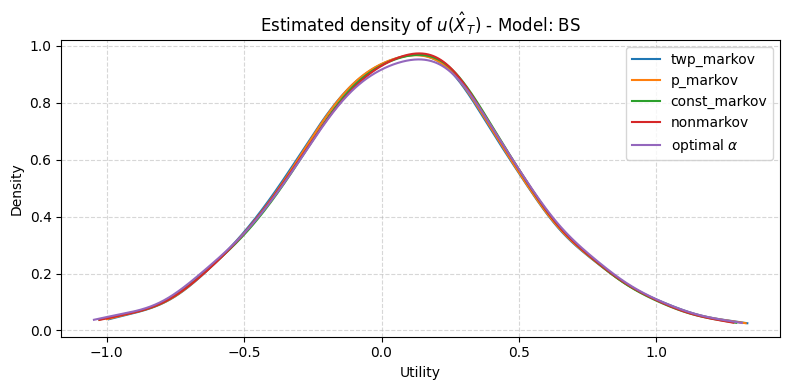

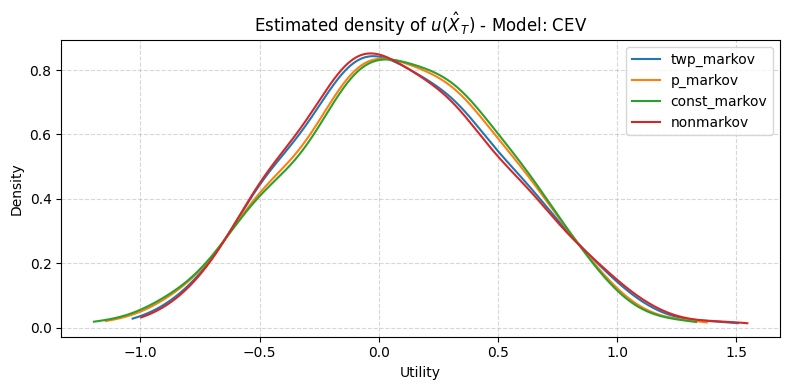

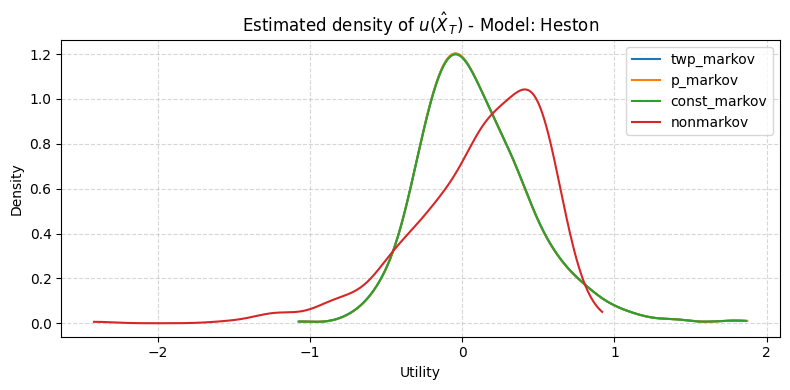

In [25]:
#@title Print the empirical density (via gaussian Kernel Density Estimation) of the utility obtained with the different trained agents

def plot_densities(values_list, title, labels):
    """
    Plot KDEs for multiple sets of utility values.

    Parameters:
    -----------
    values_list : list of np.ndarray
        Each array contains utility values (e.g., one per agent).
    title : str
        Title of the plot.
    labels : list of str
        Labels for each utility distribution (e.g., agent names).
    """
    from scipy.stats import gaussian_kde
    plt.figure(figsize=(8, 4))

    for values, label in zip(values_list, labels):
        kde = gaussian_kde(values)
        x_grid = np.linspace(min(values), max(values), 1000)
        pdf = kde(x_grid)
        plt.plot(x_grid, pdf, label=label)

    plt.title(title)
    plt.xlabel("Utility")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


for model_name in model_names:
    utility_values = []
    agent_labels = []
    price_data = prices[("test", model_name)]

    for agent_name in agents.keys():
        agent = fitted_agents[(agent_name, model_name)]

        wealth, strategy = predict(agent, price_data)
        strategy_transposed = np.transpose(strategy, (1, 0, 2))

        utilities = compute_utility(price_data, strategy_transposed, r, maturity)

        utility_values.append(utilities)
        agent_labels.append(agent_name)
    if model_name == "BS":
        optimal_strategy = np.ones(time_steps) * optimal_alpha
        utilities = compute_utility(price_data, optimal_strategy, r, maturity)

        utility_values.append(utilities)
        agent_labels.append(r"optimal $\alpha$")

    plot_densities(utility_values, title=f"Estimated density of $u(\hat X_T)$ - Model: {model_name}", labels=agent_labels)


In the above density plots, we can observe that there is significant improvement in the performance of the non-markovian strategy for the Heston model. For the rest of models and agent variations, we cannot really appreciate much difference.

Next, we can look at examples of the $\alpha_t$ values decided by the agents for some of the test paths.

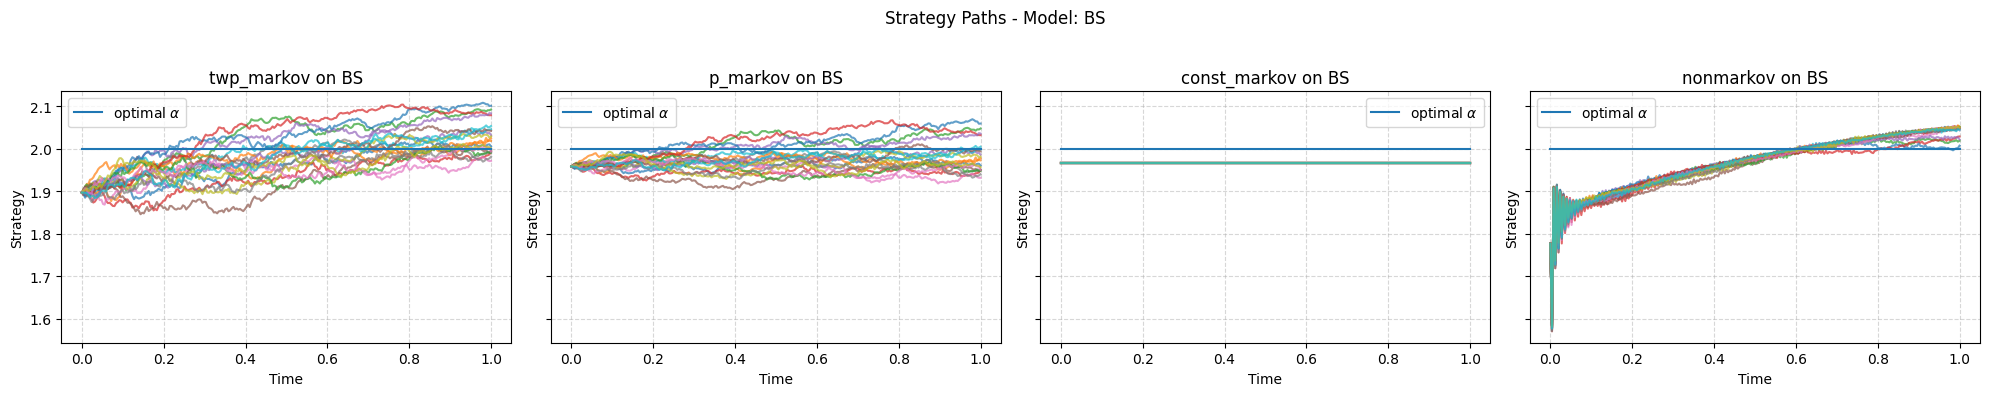

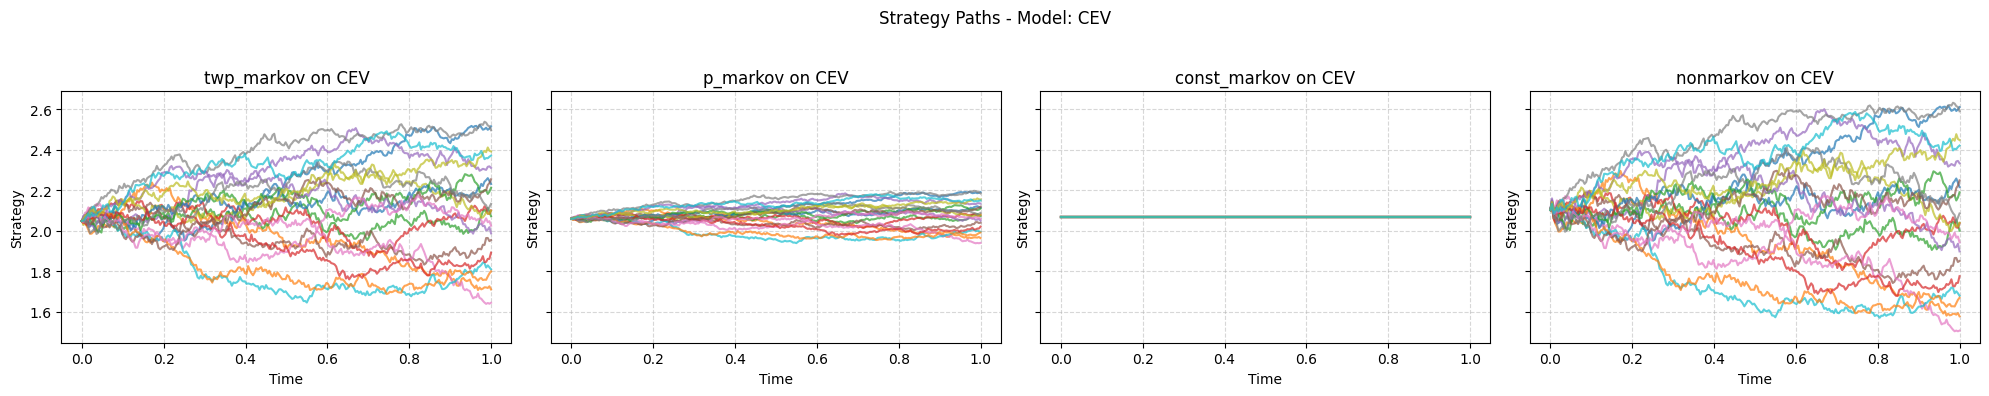

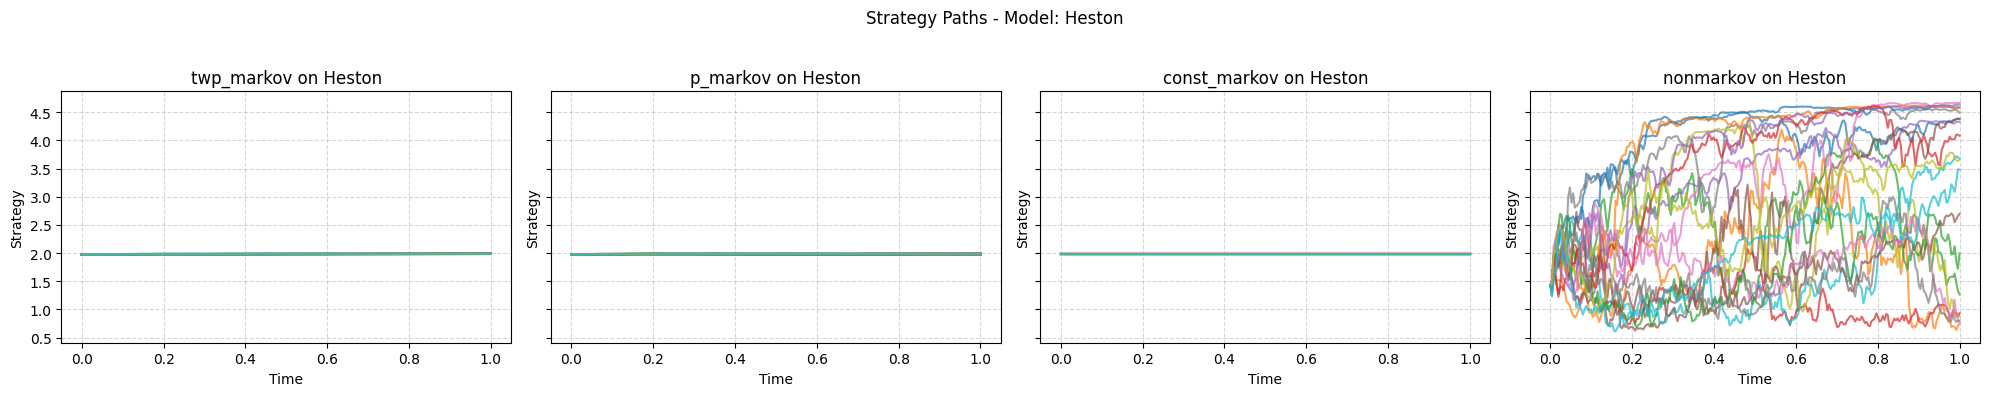

In [24]:
#@title Predicted strategy paths plot (for some of the test samples)

def plot_strategies_per_model(fitted_agents, prices, maturity, n_paths=10):
    """
    Plot strategy paths of each agent for each model.

    Parameters:
    -----------
    fitted_agents : dict
        Dict mapping (agent_name, model_name) to the agent object.
    prices : dict
        Dict mapping ("train"/"test", model_name) to price arrays.
    maturity : float
        Time horizon.
    n_paths : int
        Number of sample paths to plot.
    """
    agent_names = agents.keys()

    for model_name in model_names:
        fig, axs = plt.subplots(1, len(agent_names), figsize=(5 * len(agent_names), 4), sharey=True)
        if len(agent_names) == 1:
            axs = [axs]  # Ensure it's iterable

        for ax, agent_name in zip(axs, agent_names):
            agent = fitted_agents[(agent_name, model_name)]
            price_data = prices[("test", model_name)]  # (time_steps+1, n_paths, 1)

            _, strategy = predict(agent, price_data, verbose=False)  # (n_paths, time_steps, 1)
            strategy = strategy.squeeze(-1)  # (n_paths, time_steps)

            time_steps = strategy.shape[1]
            times = np.linspace(0, maturity, time_steps)

            # Plot a few strategy paths
            for i in range(min(n_paths, strategy.shape[0])):
                ax.plot(times, strategy[i], alpha=0.7)

            ax.set_title(f"{agent_name} on {model_name}")
            ax.set_xlabel("Time")
            ax.set_ylabel("Strategy")
            ax.grid(True, linestyle='--', alpha=0.5)
            if model_name == "BS":
                ax.plot(times, np.ones(time_steps) * optimal_alpha, label=r"optimal $\alpha$")
                ax.legend()

        plt.suptitle(f"Strategy Paths - Model: {model_name}")
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()


plot_strategies_per_model(fitted_agents, prices, maturity=1.0, n_paths=20)

Here, it might be worth noticing the big range of values that the non-markovian strategy takes with respect to the other strategies that are much more constrained. However, as we saw above, there is no significant improvement (or worsening) to these big variations of the $\alpha_t$ for the BS and CEV models. There is such an improvement in the case of the Heston model.

To further understand what happens behind the curtain of our agents, we could try to explore the output of our neural networks depending on different values for $(t, x, s)$ (current time, current wealth, current price), but this is quite complicated for the recurrent architecture of the non-markovian agent, which depends on a recurrently computed hidden state $h_i = g_{\tilde \theta}(X_{t_i}, S_{t_i}, h_{i-1}) \in \mathbb{R}^{\text{(hidden_state_dimension)}}$.